In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
from pathlib import Path

colab_project = "AI-Tutorial"
  
root_dir = Path("/content/gdrive/My Drive/")
base_dir = root_dir / "Colab Notebooks" / colab_project

data_path = base_dir / "data"
learn_path = base_dir / "learn"


In [4]:
from __future__ import print_function
import os, sys, time, datetime, json, random, collections
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout, Flatten, Conv2D

from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD , Adam, RMSprop
from tensorflow.keras.layers import PReLU, LeakyReLU
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (11, 11)


In [5]:
plt.rcParams["figure.figsize"] = (11, 11)


# 3. 코드 최종 정리

> 가운데 2 by 2가 goal이라고 가정, 이를 제외하고 랜덤하게 구조가 변경되는 것으로 생각

- 객체
    - 미로 생성
        1. `Room`
        2. `Maze`
        
    - 미로 학습
        1. `Agent`
- 학습용 코드
    1. 데이터셋 생성 (최적경로 탐색)
    2. 모델 생성 및 학습
    3. 테스트 코드

- 평가용 코드
    1. 미로 읽기: `read_maze()`
    2. 미로 탐색: `explore_maze()`
        - 실시간으로 보여줄 수 있어야함
        - 도착점 한곳에만 닿아도 
    3. 평가: `evaluate_solving()`
        - 총 걸린 시간 (회전, 이동 시간 고려)
        - 출발과 도착, 2phase에서 min 값으로 

## 3.1. 미로 학습 과정

### 미로 랜덤 생성


In [6]:
class Room:
    def __init__(self, r, c):
        self.r, self.c = r, c
        self.visit = 0
        self.prev = None
        self.drct = [(r + 1, c), (r, c + 1),
                     (r - 1, c), (r, c - 1)]
        random.shuffle(self.drct)


class Maze:
    def __init__(self, size:int=32):
        self.size = size
        self.setup()
        
    def setup(self):
        self._maze = [[Room(r, c) for c in range(self.size)] for r in range(self.size)]
        self._mazeMap = [["1" for c in range(self.size * 2 + 1)] for r in range(self.size * 2 + 1)]
        self.__make(None, self._maze[0][0], self._maze)
        

        start = self.size - 1 # ()
        end = self.size + 1 # ()
        for i in range(start, end+1):
            for j in range(start, end+1):
                self._mazeMap[i][j] = "0"
                
        self._mazeMap[start][start] = self._mazeMap[start][end] = self._mazeMap[end][start] = self._mazeMap[end][end] = "3"
        self._mazeMap[1][1] = "2"
        self.maze = self._maze
        self.mazeMap = self._mazeMap
    
    def __make(self, prev, room:Room, maze:list):
        room.prev = prev
        if room.prev is not None:
            r = prev.r - room.r
            c = prev.c - room.c
            self._mazeMap[(room.r + 1) * 2 - 1 + r][(room.c + 1) * 2 - 1 + c] = "0"
            
        
        room.visit = 1
        self._mazeMap[(room.r + 1) * 2 - 1][(room.c + 1) * 2 - 1] = "0"
        while True:
            if len(room.drct) == 0:
                break
            nr, nc = room.drct.pop()
            if nr >= 0 and nr < self.size and nc >= 0 and nc < self.size:
                if not maze[nr][nc].visit == 1:
                    self.__make(room, maze[nr][nc], maze)
                
    def save(self, filename:str='maze.txt'):
        with open(filename, 'w') as f:
            for r in self.mazeMap:
                for c in r:
                    f.write(c)
                f.write('\n')
        

In [7]:
# free cell: 0, 벽: 1, 플레이어: 2, 골인: 3
# 수정한 
import copy

plt.rcParams["figure.figsize"] = (15, 15)

visited_mark = 0.75  # Cells visited by the rat will be painted by gray 0.8
player_mark = 0.8      # The current rat cell will be painteg by gray 0.5
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# For Train
information_dict = {
    "wall": 0.3,
    "free": 0.5,
    "visited": 0.75,
    "player": 0.9,
    "goal": 1.0

}

# For Drawing
mark_dict = {
    "wall": 0.0,
    "free": 1.0,
    "player": 0.3,
    "visited": 0.6,
    "goal": 0.9
}


# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

class Agent:
    def __init__(self, maze, player="2", goal="3"):
        self._convert_dict = {
            "0": information_dict["free"], # 이동가능
            "1": information_dict["wall"], # 벽
            player: information_dict["free"], # 플레이어
            goal: information_dict["free"] # 골인지점
        }
        self.player, self.target = (), []
        self._maze = self.__convert_maze_format(maze, player, goal)
        self.nrows, self.ncols = self._maze.shape
        self.free_cells = [(r, c) for r in range(self.nrows) for c in range(self.ncols) if self._maze[r, c] == information_dict["free"]]
        for tgt in self.target:
            self.free_cells.remove(tgt)
            if self._maze[tgt] == information_dict["wall"]:
                raise Exception("Invalid maze: target cell cannot be blocked!")
        if not self.player in self.free_cells:
            raise Exception("Invalid Player Location: must sit on a free cell")
        self.reset(self.player)            

    def __convert_maze_format(self, mazeMap:list, player, goal):
        maze_copy = copy.deepcopy(mazeMap)

        for i, line in enumerate(mazeMap):
            for j, elem in enumerate(mazeMap):
                current_elem = mazeMap[i][j]
                if current_elem == player:
                    self.player = (i, j)
                elif current_elem == goal:
                    self.target.append((i, j))
                maze_copy[i][j] = self._convert_dict[current_elem]

        return np.array(maze_copy)

    def reset(self, player):
        self.player = player
        self.maze = np.copy(self._maze)
        nrows, ncols = self.maze.shape
        row, col = player
        self.maze[row, col] = player_mark
        self.state = (row, col, 'start')
        self.visited = set()

    def update_state(self, action):
        nrows, ncols = self.maze.shape
        nrow, ncol, nmode = player_row, player_col, mode = self.state

        if self.maze[player_row, player_col] > information_dict["wall"]:
            self.visited.add((player_row, player_col))  # mark visited cell

        valid_actions = self.valid_actions()
                
        if not valid_actions:
            nmode = 'blocked'
        elif action in valid_actions:
            nmode = 'valid'
            if action == LEFT:
                ncol -= 2
                self.visited.add((player_row, player_col-1))
            elif action == UP:
                nrow -= 2
                self.visited.add((player_row-1, player_col))
            if action == RIGHT:
                ncol += 2
                self.visited.add((player_row, player_col+1))
            elif action == DOWN:
                nrow += 2
                self.visited.add((player_row+1, player_col))
                
        else:                  # invalid action, no change in rat position
            mode = 'invalid'

        # new state
        self.state = (nrow, ncol, nmode)
        
    def act(self, action):
        self.update_state(action)
        envstate = self.observe()
        return envstate

    def observe(self):
        canvas = self.draw_env()
        envstate = canvas.reshape((1, -1))
        return envstate

    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > information_dict["wall"]:
                    canvas[r,c] = information_dict["free"]
        # draw the rat
        row, col, valid = self.state
        canvas[row, col] = information_dict["player"]
        return canvas

    def valid_actions(self, cell=None):
        if cell is None:
            row, col, mode = self.state
        else:
            row, col = cell
        actions = [0, 1, 2, 3]
        nrows, ncols = self.maze.shape
        ## 가장자리 제거
        if row == 1: # UP 제거
            actions.remove(1)
        elif row == nrows-2: # DOWN 제거
            actions.remove(3)

        if col == 1: # LEFT 제거 
            actions.remove(0)
        elif col == ncols-2: # RIGHT 제거
            actions.remove(2)

        if row > 1 and self.maze[row-1,col] == information_dict["wall"]:
            actions.remove(1)
        if row<nrows-2 and self.maze[row+1,col] == information_dict["wall"]:
            actions.remove(3)

        if col>1 and self.maze[row,col-1] == information_dict["wall"]:
            actions.remove(0)
        if col<ncols-2 and self.maze[row,col+1] == information_dict["wall"]:
            actions.remove(2)

        return actions

    def show(self, external_maze=None):
        plt.grid('on')
        ax = plt.gca()
        ax.set_xticks(np.arange(0.5, self.nrows, 1))
        ax.set_yticks(np.arange(0.5, self.ncols, 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        if external_maze is not None:
            canvas = np.copy(external_maze)
        else:
            canvas = np.copy(self.maze)
        nrows, ncols = canvas.shape

        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > information_dict["wall"]:
                    canvas[r,c] = mark_dict["free"]
                else:
                    canvas[r, c] = mark_dict["wall"]


        for row, col in self.visited:
            canvas[row,col] = mark_dict["visited"]

        player_row, player_col, _ = self.state
        canvas[player_row, player_col] = mark_dict["player"]
        ## Goal Cell
        for target_row, target_col in self.target:
            canvas[target_row, target_col] = mark_dict["goal"]
        img = plt.imshow(canvas, interpolation='none', cmap='gray')
        return img

    def export_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > information_dict["wall"]:
                    canvas[r,c] = information_dict["free"]
        # draw the rat
        for row, col in self.visited:
            canvas[row,col] = information_dict["visited"]

        player_row, player_col, _ = self.state
        canvas[player_row, player_col] = information_dict["player"]
        
        ## Goal Cell
        for target_row, target_col in self.target:
            canvas[target_row, target_col] = information_dict["goal"]

        return canvas.reshape((1, -1))

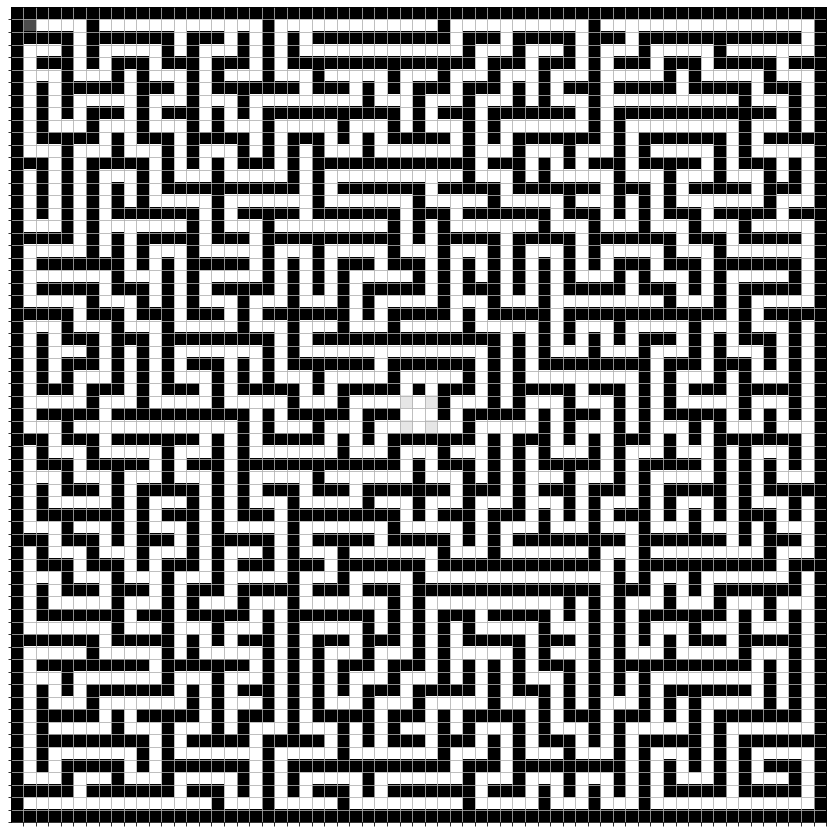

In [8]:
size = 32

maze = Maze(size)
# maze.save(f"maze_{size}_{size}.txt")

maze_agent = Agent(maze.mazeMap)
maze_agent.show()

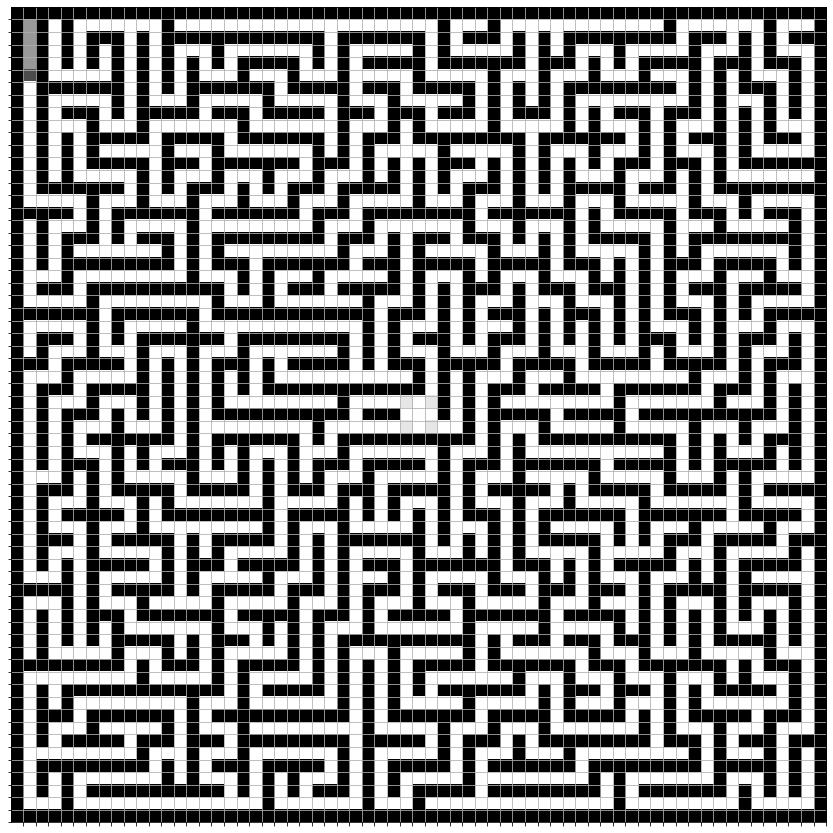

In [ ]:
maze_agent.reset((1, 1))
for action in [RIGHT, RIGHT, DOWN, DOWN, LEFT]:
    maze_agent.act(action)

maze_agent.show()

### 최적 경로 탐색

In [ ]:
def escRoot(pr, pc, prv, tree_map):
        for tmp in tree_map[pr][pc]:
            if (-1, -1) == tmp:
                sol.append((pr, pc))
                return 1
            
        for pos in tree_map[pr][pc]:
            if prv == pos:
                continue
            if escRoot(pos[0], pos[1], (pr, pc), tree_map) == 1:
                sol.append((pr, pc))
                return 1

# with open(map_path, 'r') as rf:
src = maze.mazeMap

        
mazeSize = int((len(src) - 1)/2)
tree_map, sol = [], []

## maze의 index 단위
for r in range(1, mazeSize + 1):
    tree_map.append([])
    for c in range(1, mazeSize + 1):
        tree_map[-1].append([])

## mazeMap의 index 단위
for  r in range(1, mazeSize*2, 2):
    for c in range(1, mazeSize*2, 2):
        rr, cc = int((r+1)/2)-1, int((c+1)/2)-1
        if src[r-1][c] == "0":
            tree_map[rr][cc].append((rr-1, cc))
        if src[r+1][c] == "0":
            tree_map[rr][cc].append((rr+1, cc))
        if src[r][c-1] == "0":
            tree_map[rr][cc].append((rr, cc-1))
        if src[r][c+1] == "0":
            tree_map[rr][cc].append((rr, cc+1))
                            
start = mazeSize - 1
end = mazeSize + 1

for r in range(start, end+1):
    for c in range(start, end+1):
        if src[r][c] == "3":
            tree_map[int((r+1)/2)-1][int((c+1)/2)-1].append((-1, -1))
            

escRoot(0, 0, None, tree_map)

sol.reverse()

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (5, 1), (4, 1), (4, 2), (5, 2), (6, 2), (6, 1), (7, 1), (7, 0), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (9, 4), (9, 3), (9, 2), (9, 1), (10, 1), (10, 2), (10, 3), (11, 3), (11, 2), (11, 1), (12, 1), (13, 1), (14, 1), (14, 2), (15, 2), (15, 3), (15, 4), (15, 5), (14, 5), (14, 4), (14, 3), (13, 3), (12, 3), (12, 4), (11, 4), (10, 4), (10, 5), (10, 6), (9, 6), (9, 7), (9, 8), (8, 8), (8, 9), (8, 10), (7, 10), (7, 11), (7, 12), (8, 12), (8, 13), (8, 14), (7, 14), (6, 14), (6, 13), (6, 12), (6, 11), (5, 11), (5, 12), (4, 12), (3, 12), (3, 13), (4, 13), (4, 14), (5, 14), (5, 15), (5, 16), (6, 16), (6, 17), (7, 17), (7, 16), (7, 15), (8, 15), (8, 16), (8, 17), (9, 17), (9, 16), (9, 15), (10, 15), (10, 16), (11, 16), (12, 16), (13, 16), (14, 16), (15, 16)]
[3 3 3 3 3 2 1 2 3 3 0 3 0 3 2 2 2 2 3 0 0 0 3 2 2 3 0 0 3 3 3 2 3 2 2 2 1
 0 0 1 1 2 1 1 2 2 1 2 2 1 2 2 1 2 2 3 2 2 1 1 0 0 0 1 2 1 1 2 3 2 3 2 2 3
 2 3 0 0 3 2 2 3 0 0 3 2 3 3 3 3 3]


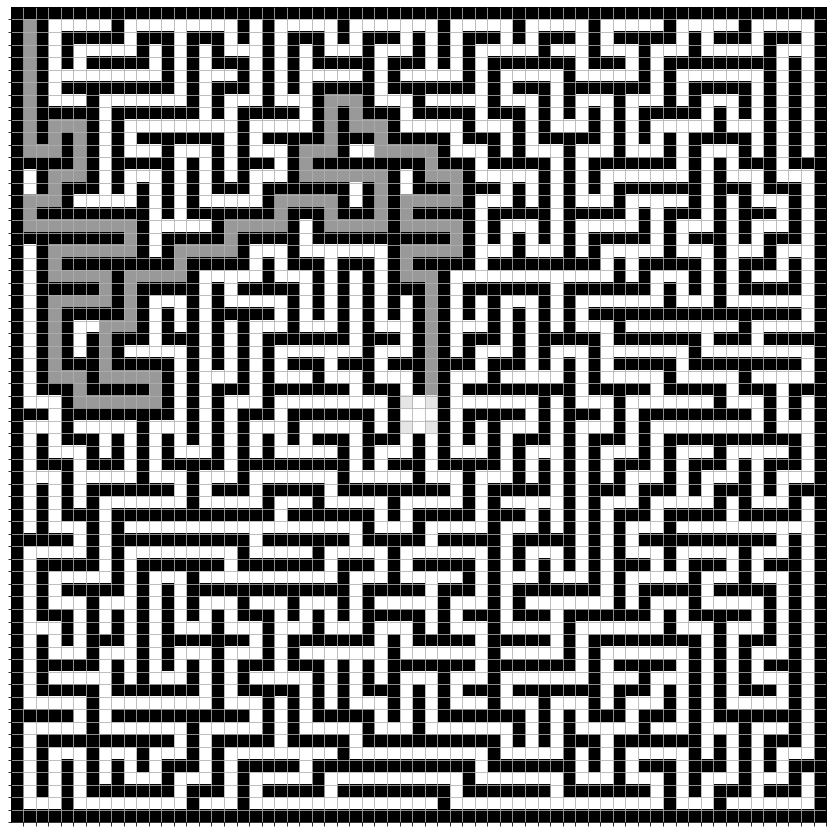

In [ ]:
maze_agent.reset((1, 1))
current_cell = sol[0]
current_state = maze_agent.export_env()
action_state = np.array([0])
action = 0
for i, (mrow, mcol) in enumerate(sol):
    if i == 0:
        continue
        
    prev_cell = current_cell
    current_cell = (mrow, mcol)
    
    action_disc = (current_cell[0] - prev_cell[0], 
                   current_cell[1] - prev_cell[1])
    if action_disc == (-1, 0):
        action = UP
    elif action_disc == (0, 1):
        action = RIGHT
    elif action_disc == (1, 0):
        action = DOWN
    elif action_disc == (0, -1):
        action = LEFT
    else:
        print("INVALID")
        break
    action_state = np.r_[action_state, np.array(action)]
    canvas = maze_agent.act(action)
    current_state = np.r_[current_state, maze_agent.export_env()]
#     print(f"{i} 번째 이동 완료 {action} 실행 {action_disc}")
    
maze_agent.show()
print(sol)    
print(action_state[1:])


In [ ]:
action_state.shape, current_state.shape

((92,), (92, 4225))

### 학습 테스트

In [ ]:
x_train = current_state[:-1].reshape(-1, size*2 + 1, size*2 + 1)[..., tf.newaxis] # 마지막 cell 제거
y_train = action_state[1:] # 첫 지정 제거
print("차원 추가 후: ",x_train.shape)


차원 추가 후:  (204, 65, 65, 1)


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(16)

In [ ]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, kernel_size=(7, 7), activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.prelu = PReLU()
    self.d2 = Dense(4, activation='softmax')

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    x = self.prelu(x)
    return self.d2(x)

In [ ]:
model = MyModel()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)


In [ ]:

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

# test_loss = tf.keras.metrics.Mean(name='test_loss')
# test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [ ]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [ ]:
EPOCHS = 1000

for epoch in range(EPOCHS):
    for images, labels in train_ds:
        train_step(images, labels)
        
    template = '에포크: {}, 손실: {}, 정확도: {}'
    if epoch % 100 == 0:
        print (template.format(epoch+1, train_loss.result(), train_accuracy.result()*100))
    
print (template.format(epoch+1, train_loss.result(), train_accuracy.result()*100))

에포크: 1, 손실: 1.3696815967559814, 정확도: 32.57122039794922
에포크: 101, 손실: 1.3686671257019043, 정확도: 32.572818756103516
에포크: 201, 손실: 1.367854118347168, 정확도: 32.57419204711914
에포크: 301, 손실: 1.3671413660049438, 정확도: 32.57538986206055
에포크: 401, 손실: 1.366525411605835, 정확도: 32.576438903808594
에포크: 501, 손실: 1.3659757375717163, 정확도: 32.577369689941406
에포크: 601, 손실: 1.3654289245605469, 정확도: 32.57819747924805
에포크: 701, 손실: 1.365002989768982, 정확도: 32.57893753051758
에포크: 801, 손실: 1.36458420753479, 정확도: 32.57960891723633
에포크: 901, 손실: 1.3642312288284302, 정확도: 32.58021926879883
에포크: 1000, 손실: 1.3639416694641113, 정확도: 32.58076477050781


# 2. 데이터 축적하자


## 2.1. 데이터 축적

In [ ]:
len(maze_agent.maze)

65

In [ ]:
import sys
sys.setrecursionlimit(10**9)

file= open('maze.txt','r')
file_s = open('maze_s.txt','w')
src = file.readlines()
file.close()


list2=[]
for item in src:
    item_mod = item.replace('0',' ')
    list2.append(item_mod)

src = list2
mazeSize = int((len(src)-1)/2)
path=[]
sol=[]
for r in range(1,mazeSize+1):
    path.append([])
    for c in range(1,mazeSize+1):
        path[-1].append([])
for r in range(1,mazeSize*2,2): # 현재 좌표 
    for c in range(1,mazeSize*2,2): # 현재 좌표 
        # (,,2) # 현재 좌표를 이용하여 
        rr,cc = int((r+1)/2)-1,int((c+1)/2)-1 # 방 좌표를 저장
    
        if src[r-1][c] == " " or src[r-1][c] == "2" or src[r-1][c] == "3":
            path[rr][cc].append((rr-1,cc)) # 위
        if src[r+1][c] == " " or src[r+1][c] == "2" or src[r+1][c] == "3":
            path[rr][cc].append((rr+1,cc)) # 아래 
        if src[r][c-1] == " " or src[r][c-1] == "2" or src[r][c-1] == "3":
            path[rr][cc].append((rr,cc-1)) # 좌 
        if src[r][c+1] == " " or src[r][c+1] == "2" or src[r][c+1] == "3":
            path[rr][cc].append((rr,cc+1)) # 우를 확인하고 벽이 뚫려있는지 확인

#         if src[r-1][c] == "0" or src[r-1][c] == "2" :
#             path[rr][cc].append((rr-1,cc)) # 위
#         if src[r+1][c] == "0" or src[r+1][c] == "2" :
#             path[rr][cc].append((rr+1,cc)) # 아래 
#         if src[r][c-1] == "0" or src[r][c-1] == "2" :
#             path[rr][cc].append((rr,cc-1)) # 좌 
#         if src[r][c+1] == "0" or src[r][c+1] == "2" :
#             path[rr][cc].append((rr,cc+1)) # 우를 확인하고 벽이 뚫려있는지 확인 

            
# for r in range(1,len(src),2): # 출구 표시 있는거 찾아오기 
#     if size == 16:
#         if src[14][14] == '3' or src[14][16] == '3' or src[16][14] == '3' or src[16][16] == '3' : # 3으로 해줘야 함 
#             path[int((r+1)/2)-1][mazeSize-1].append((-1,-1)) # 방만 포함된 좌표
#     elif size == 32:
#         if src[30][30] == '3' or src[30][32] == '3' or src[32][30] == '3' or src[32][32] == '3':
#             path[int((r+1)/2)-1][mazeSize-1].append((-1,-1))

path[int(size/2)][int(size/2)-1].append((-1,-1))
path[int(size/2)][int(size/2)].append((-1,-1))
path[int(size/2)-1][int(size/2)].append((-1,-1))
path[int(size/2)-1][int(size/2)-1].append((-1,-1))
         
def escRoot(pr, pc, prv): # pr pc 현재방의 좌표 prv 이전 방의 좌표 
    for tmp in path[pr][pc]: # 종료분기 설정 출구 방의 정보가 있따면
        if (-1, -1) == tmp: 
            sol.append((pr,pc))
            return 1
    for pos in path[pr][pc]: # 출구 방의 정보가 없다면 
        if prv == pos:
            continue
        if escRoot(pos[0], pos[1], (pr,pc)) == 1:
            sol.append((pr,pc))
            return 1
    
            
escRoot(0,0,None)

sol.reverse()
print(sol)

for i,a in enumerate(src):
    src[i] = list(a)
for lv in range(len(sol)-1):
    r,c = sol[lv]
    rr = sol[lv+1][0] -r
    cc = sol[lv+1][1] -c
    if rr == 1 and cc == 0:
        dr = '↓'
    if rr == 0 and cc == 1:
        dr = '→'
    if rr == -1 and cc == 0:
        dr = '↑'
    if rr == 0 and cc == -1:
        dr = '←'
    src[(r+1)*2-1][(c+1)*2-1] = dr
for a in src:
    file_s.writelines(a)
file_s.close()

In [ ]:

def return_dataset(maze:Maze, maze_agent:Agent):
    def escRoot(pr, pc, prv, tree_map):
        for tmp in tree_map[pr][pc]:
            if (-1, -1) == tmp:
                sol.append((pr, pc))
                return 1
            
        for pos in tree_map[pr][pc]:
            if prv == pos:
                continue
            if escRoot(pos[0], pos[1], (pr, pc), tree_map) == 1:
                sol.append((pr, pc))
                return 1

    # with open(map_path, 'r') as rf:
    src = maze.mazeMap
    
            
    mazeSize = int((len(src) - 1)/2)
    tree_map, sol = [], []

    ## maze의 index 단위
    for r in range(1, mazeSize + 1):
        tree_map.append([])
        for c in range(1, mazeSize + 1):
            tree_map[-1].append([])
    
    ## mazeMap의 index 단위
    for  r in range(1, mazeSize*2, 2):
        for c in range(1, mazeSize*2, 2):
            rr, cc = int((r+1)/2)-1, int((c+1)/2)-1
            if src[r-1][c] == "0":
                tree_map[rr][cc].append((rr-1, cc))
            if src[r+1][c] == "0":
                tree_map[rr][cc].append((rr+1, cc))
            if src[r][c-1] == "0":
                tree_map[rr][cc].append((rr, cc-1))
            if src[r][c+1] == "0":
                tree_map[rr][cc].append((rr, cc+1))
                                
    start = mazeSize - 1
    end = mazeSize + 1
    
    for r in range(start, end+1):
        for c in range(start, end+1):
            if src[r][c] == "3":
                tree_map[int((r+1)/2)-1][int((c+1)/2)-1].append((-1, -1))
                
    
    escRoot(0, 0, None, tree_map)

    sol.reverse()


    maze_agent.reset((1, 1))
    current_cell = sol[0]
    current_state = maze_agent.export_env()
    action_state = np.array([0])
    action = -1
    for i, (mrow, mcol) in enumerate(sol):
        if i == 0:
            continue
            
        prev_cell = current_cell
        current_cell = (mrow, mcol)
        
        action_disc = (current_cell[0] - prev_cell[0], 
                    current_cell[1] - prev_cell[1])
        if action_disc == (-1, 0):
            action = UP
        elif action_disc == (0, 1):
            action = RIGHT
        elif action_disc == (1, 0):
            action = DOWN
        elif action_disc == (0, -1):
            action = LEFT
        else:
            print("INVALID")
            break
        action_state = np.r_[action_state, np.array(action)]
        canvas = maze_agent.act(action)
        current_state = np.r_[current_state, maze_agent.export_env()]
    #     print(f"{i} 번째 이동 완료 {action} 실행 {action_disc}")
    return current_state[:-1], action_state[1:]



In [ ]:
size = 32
iteration = 800 # iteration 당 하나의 랜덤 미로 세트
# filename = f"maze_{size}_{size}.txt"
maze = Maze(size)
# maze.save(filename)

maze_agent = Agent(maze.mazeMap)
data_x, data_y = return_dataset(maze, maze_agent)

for i in range(iteration):
    maze = Maze(size)
    maze.save(f"maze_{size}_{size}.txt")

    maze_agent = Agent(maze.mazeMap)
    data_x_sub, data_y_sub = return_dataset(maze, maze_agent)
    data_x = np.r_[data_x, data_x_sub]
    data_y = np.r_[data_y, data_y_sub]
    if i % 50 == 0:
        print(f"{i} 번째 축적 완료, shape: {data_x.shape}")
print(f"{i} 번째 축적 완료, shape: {data_x.shape}")

0 번째 축적 완료, shape: (410, 4225)
50 번째 축적 완료, shape: (14469, 4225)
100 번째 축적 완료, shape: (27844, 4225)
150 번째 축적 완료, shape: (41778, 4225)
200 번째 축적 완료, shape: (55248, 4225)
250 번째 축적 완료, shape: (68672, 4225)
300 번째 축적 완료, shape: (81630, 4225)
350 번째 축적 완료, shape: (95541, 4225)
400 번째 축적 완료, shape: (108722, 4225)
450 번째 축적 완료, shape: (124046, 4225)
500 번째 축적 완료, shape: (138535, 4225)
550 번째 축적 완료, shape: (152767, 4225)
600 번째 축적 완료, shape: (167825, 4225)
650 번째 축적 완료, shape: (181906, 4225)
700 번째 축적 완료, shape: (196028, 4225)
750 번째 축적 완료, shape: (209079, 4225)
799 번째 축적 완료, shape: (223020, 4225)


In [ ]:
np.save(data_path / f"data_x_{size}_{size}_{800}-total.npy", data_x)
np.save(data_path / f"data_y_{size}_{size}_{800}-total.npy", data_y)

0: LEFT / 1: UP / 2: RIGHT / 3: DOWN
3


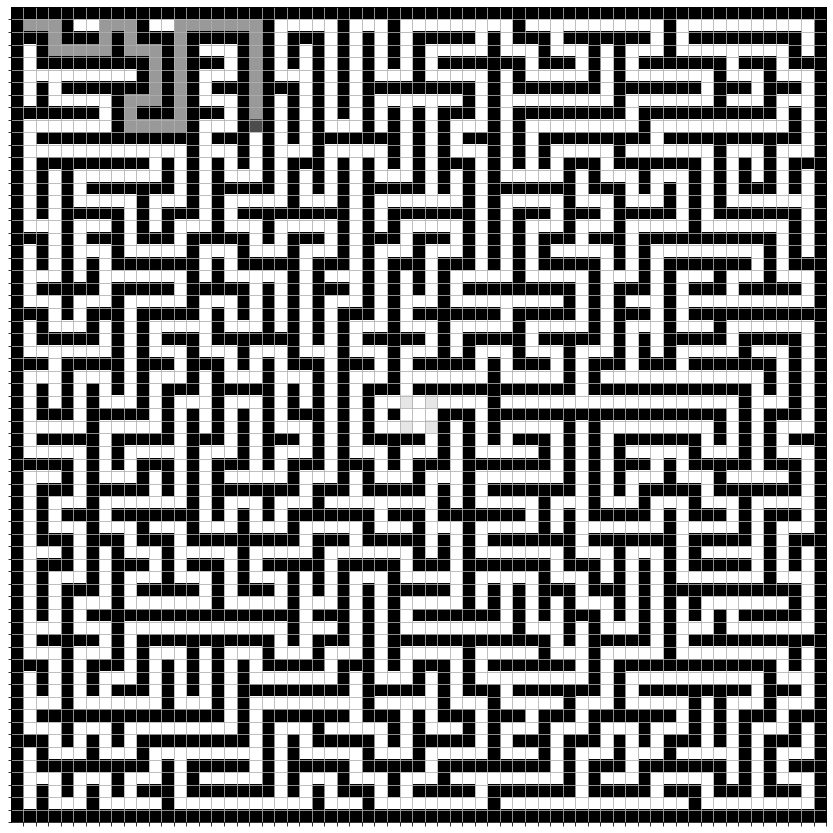

In [ ]:
def show_maze_x(maze):
    canvas = np.copy(maze)   
    nrows, ncols = canvas.shape

    plt.grid('on')
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    player_row, player_col = map(int, np.where(canvas == information_dict["player"]))
    visited_row, visited_col = np.where(canvas == information_dict["visited"])
    goal_row, goal_col = np.where(canvas == information_dict["goal"])

    for r in range(nrows):
        for c in range(ncols):
            if canvas[r,c] > information_dict["wall"]:
                canvas[r,c] = mark_dict["free"]
            else:
                canvas[r, c] = mark_dict["wall"]

            for i in range(len(visited_row)):
                canvas[int(visited_row[i]), int(visited_col[i])] = mark_dict["visited"]

    
    canvas[player_row, player_col] = mark_dict["player"]
    ## Goal Cell
    for i in range(len(goal_row)):
        canvas[goal_row[i], goal_col[i]] = mark_dict["goal"]
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

# maze_agent.show(x_train[3].reshape((21, 21)))\
idx = 20000
show_maze_x(data_x[idx].reshape((size*2+1, size*2+1)))
print("0: LEFT / 1: UP / 2: RIGHT / 3: DOWN")
print(data_y[idx])

In [ ]:
np.save(data_path / f"data_x_{size}_{size}_{500}-new.npy", data_x)
np.save(data_path / f"data_y_{size}_{size}_{500}-new.npy", data_y)


In [ ]:
# 라벨 분포 보기

total_num = len(data_y)
for label in set(data_y):
    print(f"{label}: {np.sum(data_y == label) / total_num * 100: .2f}%", end="\n")


0:  22.21%
1:  22.23%
2:  27.76%
3:  27.80%


## 2.2. 데이터 학습

In [ ]:
size = 32
# data_x = np.r_[np.load(data_path / f"data_x_{size}_{size}_300.npy"), np.load(data_path / f"data_x_{size}_{size}_500-new.npy")] 
# data_y = np.r_[np.load(data_path / f"data_y_{size}_{size}_300.npy"), np.load(data_path / f"data_y_{size}_{size}_500-new.npy")]
# print(data_x.shape, data_y.shape)


In [ ]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.1, 
                                                    shuffle=True, 
                                                    random_state=42)


print(x_train.shape, y_train.shape)

(200718, 4225) (200718,)


In [ ]:
x_train, x_test = x_train[..., tf.newaxis], x_test[..., tf.newaxis]
x_train.shape, x_test.shape


((200718, 4225, 1), (22302, 4225, 1))

In [ ]:
n_output = 4
y_train = tf.keras.utils.to_categorical(y_train, n_output) # 원핫 코드로 변환
y_test = tf.keras.utils.to_categorical(y_test, n_output)

y_train.shape, y_test.shape

((200718, 4), (22302, 4))

In [ ]:
map_size = size * 2 + 1

x_train, x_test = x_train.reshape(-1, map_size, map_size, 1), x_test.reshape(-1, map_size, map_size, 1)

In [ ]:
x_train.shape

(200718, 65, 65, 1)

In [ ]:
## ConvNet C-C-C-F-Drop
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, kernel_size=(7, 7)),
  tf.keras.layers.PReLU(),
  tf.keras.layers.Conv2D(16, kernel_size=(9, 9)),
  tf.keras.layers.PReLU(),
  tf.keras.layers.Conv2D(8, kernel_size=(11, 11)),
  tf.keras.layers.PReLU(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(512),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.PReLU(),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(128),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.PReLU(),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(4, activation='softmax')
])

# model.compile(optimizer=Adam(learning_rate=3e-01), loss='mse')

## Simple Neural Network
# model = tf.keras.models.Sequential([
                                    
# #   tf.keras.layers.Conv2D(64, kernel_size=(7, 7)),
# #   tf.keras.layers.PReLU(),
# #   tf.keras.layers.MaxPool2D((3, 3)),
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(units=size**2),
#   tf.keras.layers.BatchNormalization(),
#   tf.keras.layers.PReLU(),
#   tf.keras.layers.Dropout(0.25),
#   tf.keras.layers.Dense(units=size**2),
#   tf.keras.layers.BatchNormalization(),
#   tf.keras.layers.PReLU(),
#   tf.keras.layers.Dropout(0.25),
#   tf.keras.layers.Dense(units=size**3),
#   tf.keras.layers.BatchNormalization(),
#   tf.keras.layers.PReLU(),
#   tf.keras.layers.Dropout(0.25),
#   tf.keras.layers.Dense(units=size),
#   tf.keras.layers.BatchNormalization(),
#   tf.keras.layers.PReLU(),
#   tf.keras.layers.Dropout(0.25),
#   tf.keras.layers.Dense(4, activation='softmax')
# ])


model.compile(optimizer=Adam(learning_rate=5e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# model = tf.keras.models.load_model(learn_path / "maze_32_32_model_300-f2")

In [ ]:
hist = model.fit(x_train, y_train, batch_size=32, epochs=60,
               validation_data=(x_test, y_test), verbose=1)

res = model.evaluate(x_test, y_test, verbose=0)
print(res)

Epoch 1/60
6273/6273 [==============================] - 69s 8ms/step - loss: 1.3728 - accuracy: 0.3026 - val_loss: 1.3591 - val_accuracy: 0.3133
Epoch 2/60
6273/6273 [==============================] - 53s 8ms/step - loss: 1.3606 - accuracy: 0.3129 - val_loss: 1.3581 - val_accuracy: 0.3136
Epoch 3/60
6273/6273 [==============================] - 52s 8ms/step - loss: 1.3584 - accuracy: 0.3160 - val_loss: 1.4881 - val_accuracy: 0.3019
Epoch 4/60
6273/6273 [==============================] - 52s 8ms/step - loss: 1.3559 - accuracy: 0.3175 - val_loss: 1.3672 - val_accuracy: 0.3079
Epoch 5/60
6273/6273 [==============================] - 52s 8ms/step - loss: 1.3528 - accuracy: 0.3223 - val_loss: 1.4038 - val_accuracy: 0.2527
Epoch 6/60
6273/6273 [==============================] - 52s 8ms/step - loss: 1.3491 - accuracy: 0.3274 - val_loss: 1.3596 - val_accuracy: 0.3283
Epoch 7/60
6273/6273 [==============================] - 52s 8ms/step - loss: 1.3459 - accuracy: 0.3323 - val_loss: 1.3432 - val_ac

In [ ]:
model.save(learn_path / f"maze_{size}_{size}_model_data800-epoch60-lr005-01") 

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/AI-Tutorial/learn/maze_32_32_model_data800-epoch60-lr005-01/assets


In [ ]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 59, 59, 32)        1600      
_________________________________________________________________
p_re_lu_5 (PReLU)            (None, 59, 59, 32)        111392    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 51, 51, 16)        41488     
_________________________________________________________________
p_re_lu_6 (PReLU)            (None, 51, 51, 16)        41616     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 41, 41, 8)         15496     
_________________________________________________________________
p_re_lu_7 (PReLU)            (None, 41, 41, 8)         13448     
_________________________________________________________________
flatten_1 (Flatten)          (None, 13448)            

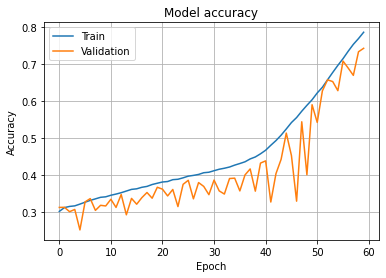

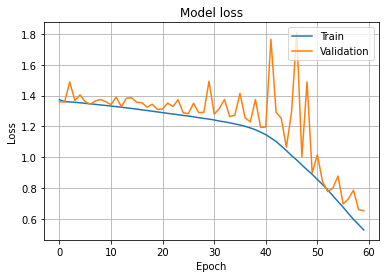

In [ ]:
import matplotlib.pyplot as plt

# 정확률 곡선
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title("Model accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid()
plt.show()


# 손실 함수 곡선
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid()
plt.show()

### 추가 학습

In [ ]:
hist2 = model.fit(x_train, y_train, batch_size=32, epochs=60,
               validation_data=(x_test, y_test), verbose=1)
res = model.evaluate(x_test, y_test, verbose=0)


Epoch 1/60
6273/6273 [==============================] - 53s 8ms/step - loss: 0.4945 - accuracy: 0.8007 - val_loss: 0.6548 - val_accuracy: 0.7375
Epoch 2/60
6273/6273 [==============================] - 53s 8ms/step - loss: 0.4611 - accuracy: 0.8149 - val_loss: 0.5360 - val_accuracy: 0.7817
Epoch 3/60
6273/6273 [==============================] - 52s 8ms/step - loss: 0.4321 - accuracy: 0.8289 - val_loss: 0.4642 - val_accuracy: 0.8204
Epoch 4/60
6273/6273 [==============================] - 53s 8ms/step - loss: 0.4016 - accuracy: 0.8424 - val_loss: 0.5350 - val_accuracy: 0.7864
Epoch 5/60
6273/6273 [==============================] - 53s 8ms/step - loss: 0.3737 - accuracy: 0.8550 - val_loss: 0.4607 - val_accuracy: 0.8235
Epoch 6/60
6273/6273 [==============================] - 53s 8ms/step - loss: 0.3465 - accuracy: 0.8661 - val_loss: 0.4379 - val_accuracy: 0.8297
Epoch 7/60
6273/6273 [==============================] - 52s 8ms/step - loss: 0.3214 - accuracy: 0.8769 - val_loss: 0.3602 - val_ac

In [ ]:
model.save(learn_path / f"maze_{size}_{size}_model_data800-epoch60-lr005-02") 

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Colab Notebooks/AI-Tutorial/learn/maze_32_32_model_data800-epoch60-lr005-02/assets


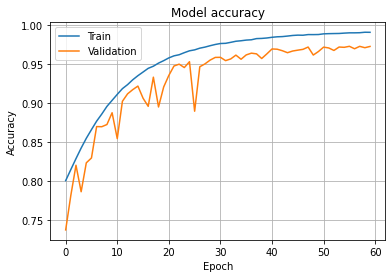

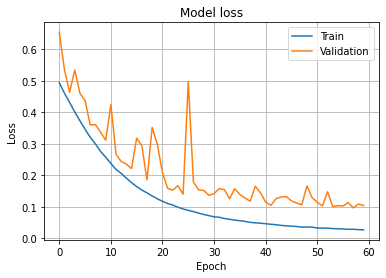

In [ ]:
# 정확률 곡선
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title("Model accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid()
plt.show()


# 손실 함수 곡선
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title("Model loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid()
plt.show()


## 2.3. 학습 평가

In [ ]:
def show_maze_x(maze):
    canvas = np.copy(maze)   
    nrows, ncols = canvas.shape

    plt.grid('on')
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    player_row, player_col = map(int, np.where(canvas == information_dict["player"]))
    visited_row, visited_col = np.where(canvas == information_dict["visited"])
    goal_row, goal_col = np.where(canvas == information_dict["goal"])

    for r in range(nrows):
        for c in range(ncols):
            if canvas[r,c] > information_dict["wall"]:
                canvas[r,c] = mark_dict["free"]
            else:
                canvas[r, c] = mark_dict["wall"]

            for i in range(len(visited_row)):
                canvas[int(visited_row[i]), int(visited_col[i])] = mark_dict["visited"]

    
    canvas[player_row, player_col] = mark_dict["player"]
    ## Goal Cell
    for i in range(len(goal_row)):
        canvas[goal_row[i], goal_col[i]] = mark_dict["goal"]
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

# # maze_agent.show(x_train[3].reshape((21, 21)))\
# idx = 10000
# show_maze_x(data_x[idx].reshape((size*2+1, size*2+1)))
# print("0: LEFT / 1: UP / 2: RIGHT / 3: DOWN")
# print(data_y[idx])

1: LEFT / 2: UP / 3: RIGHT / 4: DOWN
실제 Y: [0. 0. 1. 0.] / 예측 Y: [[7.1125115e-09 5.0720479e-07 9.9999940e-01 1.7549303e-07]]


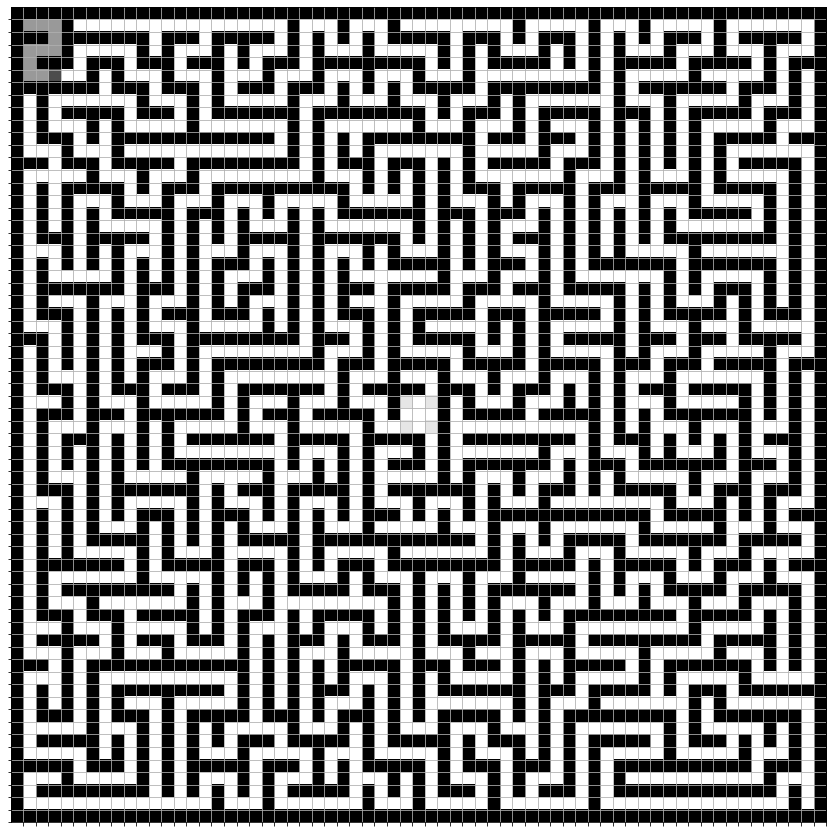

In [ ]:
# maze_agent.show(x_train[3].reshape((21, 21)))\
idx = 10002
_x = x_test[idx]
show_maze_x(_x.reshape(size*2+1, size*2+1))
print("1: LEFT / 2: UP / 3: RIGHT / 4: DOWN")
print(f"실제 Y: {y_test[idx]} / 예측 Y: {model(_x[tf.newaxis, ...])}")

### 미로 랜덤 케이스

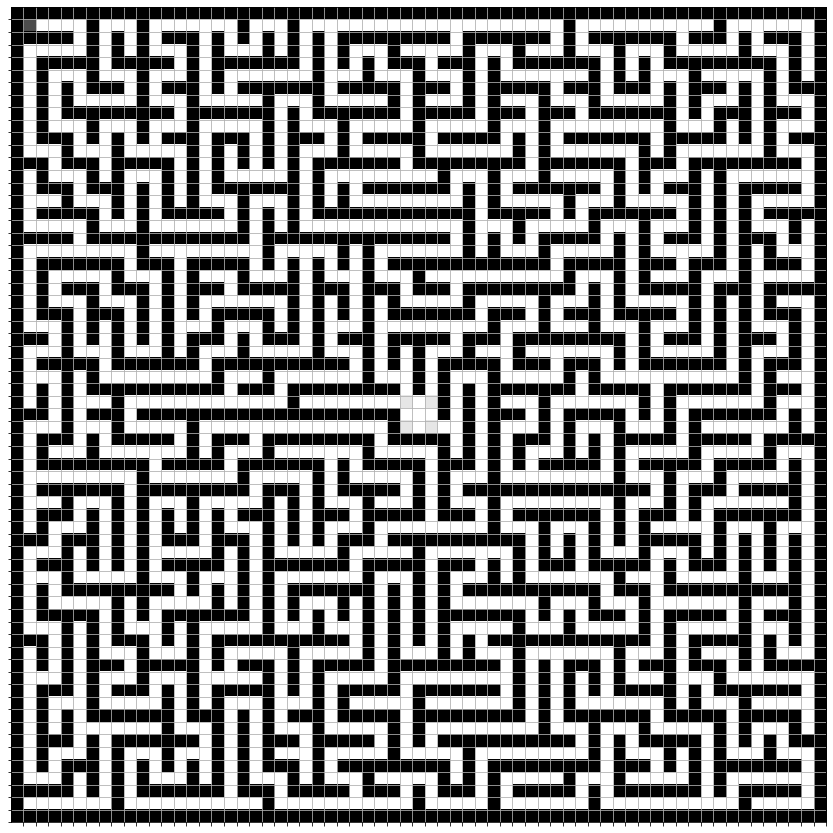

In [ ]:
size = 32

maze = Maze(size)
# maze.save(f"maze_{size}_{size}.txt")

maze_agent = Agent(maze.mazeMap)
maze_agent.show()

In [ ]:
# maze_agent.act(DOWN)
# maze_agent.valid_actions()

62번째: invalid! break, 다른 대안 [2]


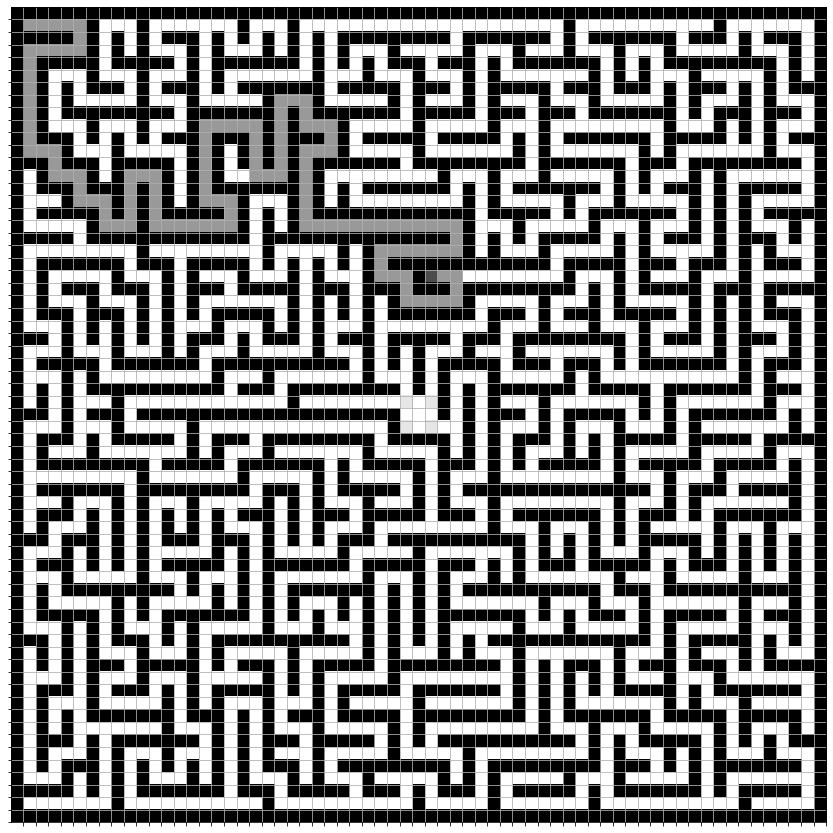

In [ ]:
# maze_agent.show()
maze_agent.reset((1, 1))

for i in range(100):
    maze_state = maze_agent.export_env().reshape((1, size*2+1, size*2+1))[..., tf.newaxis]
    predicted_action = np.argmax(model(maze_state))
    val_action = maze_agent.valid_actions()
    if predicted_action in val_action:
        state = 'valid'
        maze_agent.act(predicted_action)
    else:
        state = 'invalid'
        # val_action.remove(predicted_action)
        print(f"{i}번째: {state}! break, 다른 대안 {val_action}")
        break
maze_agent.show()

In [ ]:
maze_agent.act(UP)

array([[0.3, 0.3, 0.3, ..., 0.3, 0.3, 0.3]])

In [ ]:
predicted_action

0

0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100101102103104105106107108109110111112113114115116117118119120121122123124125126127128129130131132133134135136137138139140141142143144145146147148149150151152153154155156157158159160161162163164165166167168169170171172173174175176177178179180181182183184185186187188189190191192193194195196197198199

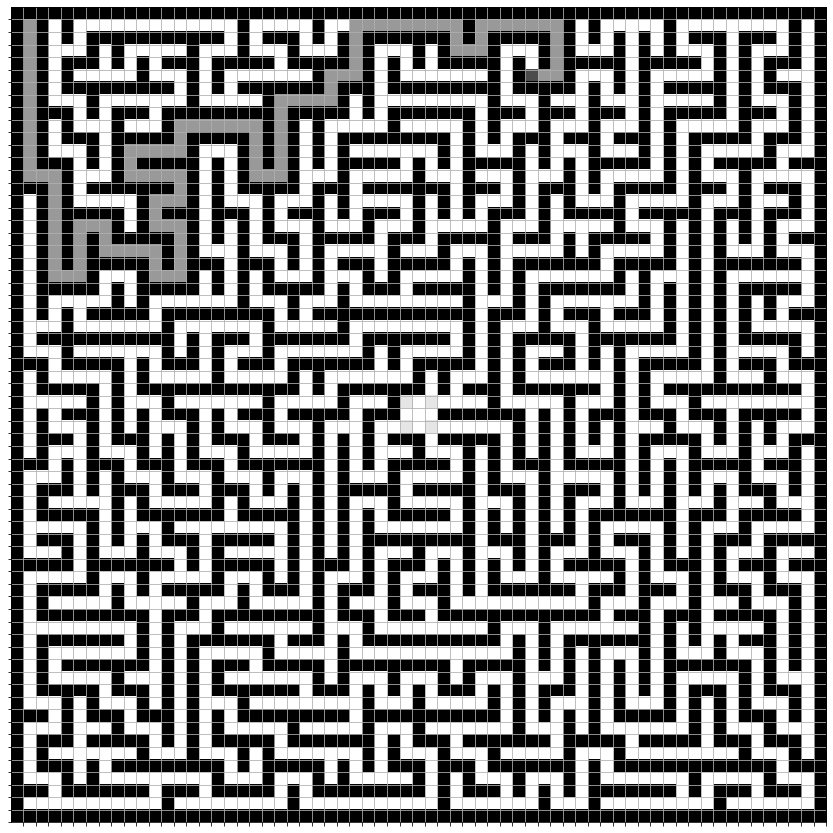

In [ ]:
maze_agent.reset((1, 1))
for i in range(200):
    maze_agent
    maze_state = maze_agent.export_env().reshape((1, size*2+1, size*2+1))[..., tf.newaxis]
    action = np.argmax(model(maze_state))
    env = maze_agent.act(action)
    # else:

    print(i, end="")

maze_agent.show()



In [ ]:
def escRoot(pr, pc, prv, tree_map):
        for tmp in tree_map[pr][pc]:
            if (-1, -1) == tmp:
                sol.append((pr, pc))
                return 1
            
        for pos in tree_map[pr][pc]:
            if prv == pos:
                continue
            if escRoot(pos[0], pos[1], (pr, pc), tree_map) == 1:
                sol.append((pr, pc))
                return 1

# with open(map_path, 'r') as rf:
src = maze.mazeMap

        
mazeSize = int((len(src) - 1)/2)
tree_map, sol = [], []

## maze의 index 단위
for r in range(1, mazeSize + 1):
    tree_map.append([])
    for c in range(1, mazeSize + 1):
        tree_map[-1].append([])

## mazeMap의 index 단위
for  r in range(1, mazeSize*2, 2):
    for c in range(1, mazeSize*2, 2):
        rr, cc = int((r+1)/2)-1, int((c+1)/2)-1
        if src[r-1][c] == "0":
            tree_map[rr][cc].append((rr-1, cc))
        if src[r+1][c] == "0":
            tree_map[rr][cc].append((rr+1, cc))
        if src[r][c-1] == "0":
            tree_map[rr][cc].append((rr, cc-1))
        if src[r][c+1] == "0":
            tree_map[rr][cc].append((rr, cc+1))
                            
start = mazeSize - 1
end = mazeSize + 1

for r in range(start, end+1):
    for c in range(start, end+1):
        if src[r][c] == "3":
            tree_map[int((r+1)/2)-1][int((c+1)/2)-1].append((-1, -1))
            

escRoot(0, 0, None, tree_map)

sol.reverse()

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (10, 2), (9, 2), (8, 2), (8, 3), (9, 3), (9, 4), (9, 5), (10, 5), (10, 6), (9, 6), (8, 6), (8, 5), (7, 5), (7, 6), (6, 6), (6, 5), (6, 4), (5, 4), (5, 5), (5, 6), (4, 6), (4, 7), (4, 8), (4, 9), (5, 9), (6, 9), (6, 10), (5, 10), (4, 10), (3, 10), (3, 11), (3, 12), (2, 12), (2, 13), (1, 13), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (1, 17), (1, 18), (0, 18), (0, 19), (0, 20), (0, 21), (1, 21), (2, 21), (2, 20), (1, 20), (1, 19), (2, 19), (3, 19), (3, 20), (4, 20), (4, 19), (5, 19), (5, 18), (4, 18), (3, 18), (3, 17), (3, 16), (3, 15), (3, 14), (4, 14), (4, 13), (4, 12), (5, 12), (6, 12), (6, 11), (7, 11), (7, 10), (8, 10), (8, 11), (9, 11), (10, 11), (10, 10), (9, 10), (9, 9), (8, 9), (7, 9), (7, 8), (6, 8), (5, 8), (5, 7), (6, 7), (7, 7), (8, 7), (9, 7), (9, 8), (10, 8), (11, 8), (11, 7), (11, 6), (11, 5), (12, 5), (12, 4), (12, 3), (12, 2), (11, 2), (11, 1), (12, 1), (12, 0), (13, 0),

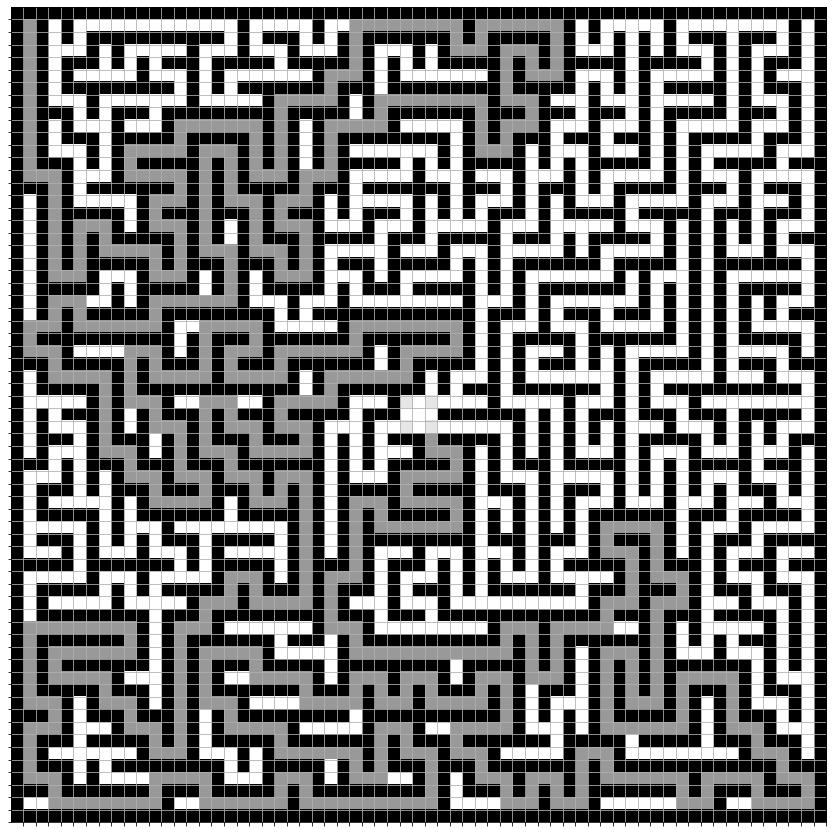

In [ ]:
maze_agent.reset((1, 1))
current_cell = sol[0]
current_state = maze_agent.export_env()
action_state = np.array([0])
action = 0
for i, (mrow, mcol) in enumerate(sol):
    if i == 0:
        continue
        
    prev_cell = current_cell
    current_cell = (mrow, mcol)
    
    action_disc = (current_cell[0] - prev_cell[0], 
                   current_cell[1] - prev_cell[1])
    if action_disc == (-1, 0):
        action = UP
    elif action_disc == (0, 1):
        action = RIGHT
    elif action_disc == (1, 0):
        action = DOWN
    elif action_disc == (0, -1):
        action = LEFT
    else:
        print("INVALID")
        break
    action_state = np.r_[action_state, np.array(action)]
    canvas = maze_agent.act(action)
    current_state = np.r_[current_state, maze_agent.export_env()]
#     print(f"{i} 번째 이동 완료 {action} 실행 {action_disc}")
    
maze_agent.show()
print(sol)    
print(action_state[1:])


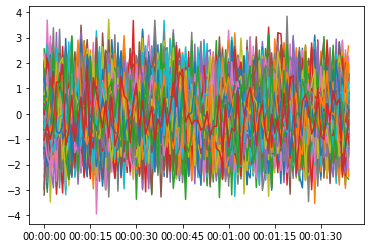

# 참고자료

## 신경망 디자인

- https://towardsdatascience.com/designing-your-neural-networks-a5e4617027ed
- https://towardsdatascience.com/beyond-the-standard-cnn-in-tensorflow-2-a7562d25ca2d
- https://github.com/rajat28/maze-problem/blob/master/MazeProblem.py

## 일반화 및 정규화

- https://blog.slavv.com/37-reasons-why-your-neural-network-is-not-working-4020854bd607
- https://www.kakaobrain.com/blog/9
- https://stats.stackexchange.com/questions/352036/what-should-i-do-when-my-neural-network-doesnt-learn